# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1dS8IKYdG0yxFne6Ebva6xgvCW8yHP0xU?pli=1&authuser=2#scrollTo=LfiFE_WOqIDu

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

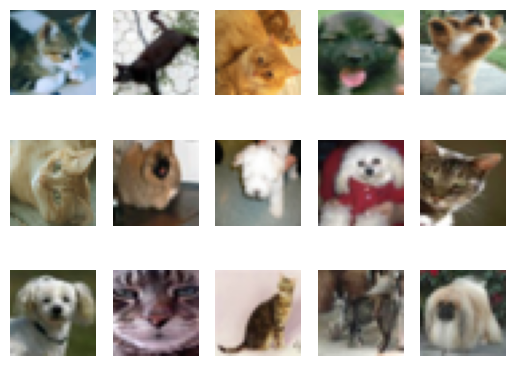

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
wantclasses=[]
wantclasses.append("cat")
wantclasses.append("dog")

train,valid,test,get=get_data_loader(wantclasses,1)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
ctrain = 0
cvalid = 0
ctest = 0
dtrain = 0
dvalid = 0
dtest = 0

for images, labels in train:
    for image, label in zip(images, labels):
        if label == 3:
            ctrain += 1
        elif label == 5:
            dtrain += 1

for images, labels in valid:
    for image, label in zip(images, labels):
        if label == 3:
            cvalid += 1
        elif label == 5:
            dvalid += 1

for images, labels in test:
    for image, label in zip(images, labels):
        if label == 3:
            ctest += 1
        elif label == 5:
            dtest += 1

In [ ]:
print(f"Total training: {len(train)}")
print(f"Total validation: {len(valid)}")
print(f"Total testing: {len(test)}")
print(f"Cat training: {ctrain}")
print(f"Cat validation: {cvalid}")
print(f"Cat testing: {ctest}")
print(f"Dog training: {dtrain}")
print(f"Dog validation: {dvalid}")
print(f"Dog testing: {dtest}")

"""There are 8000 training examples (4018 cat and 3982 dog), 2000 validation
examples(982 cat and 1018 dog), and 2000 test examples (1000 cat and 1000 dog)"""

Total training: 8000
Total validation: 2000
Total testing: 2000
Cat training: 4018
Cat validation: 982
Cat testing: 1000
Dog training: 3982
Dog validation: 1018
Dog testing: 1000


'There are 8000 training examples (4018 cat and 3982 dog), 2000 validation\nexamples(982 cat and 1018 dog), and 2000 test examples (1000 cat and 1000 dog)'

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
"""The validation set allows us to evaluate our model during training without
fear of bias and memorization. It helps us to check in on the model during tra-
ining with new unseen data and allows us to keep our test data hidden until the
model is completed. If we judged our model using the training set loss/error
then we may be getting biased results since the network has seen the data before
and has developed a bias towards it. The model has learned on the training data,
and therefore will yield better results when performing with it than the vali-
dation or testing data."""

'The validation set allows us to evaluate our model during training without\nfear of bias and memorization. It helps us to check in on the model during tra-\nining with new unseen data and allows us to keep our test data hidden until the\nmodel is completed. If we judged our model using the training set loss/error\nthen we may be getting biased results since the network has seen the data before\nand has developed a bias towards it. The model has learned on the training data,\nand therefore will yield better results when performing with it than the vali-\ndation or testing data.'

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small_param=0
for param in small_net.parameters():
  small_param+=param.numel()
large_param=0
for param in large_net.parameters():
  large_param+=param.numel()

print(small_param)
print(large_param)

"""small_net has 386 parameters and large_net has 9705 parameters"""


386
9705


'small_net has 386 parameters and large_net has 9705 parameters'

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size, learning_rate, num_epochs):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    a=np.savetxt("{}_train_err.csv".format(model_path), train_err)
    b=np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    c=np.savetxt("{}_val_err.csv".format(model_path), val_err)
    d=np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
"""Based on a simple read through of the function, default batch_size=64,
learning_rate=0.01, num_epochs=30"""

'Based on a simple read through of the function, default batch_size=64,\nlearning_rate=0.01, num_epochs=30'

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, 64, 0.01, 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431125, Train loss: 0.6764993209838868 |Validation err: 0.3705, Validation loss: 0.6539373937994242
Epoch 2: Train err: 0.3715, Train loss: 0.6476548590660095 |Validation err: 0.389, Validation loss: 0.661908283829689
Epoch 3: Train err: 0.355625, Train loss: 0.6378512964248657 |Validation err: 0.3465, Validation loss: 0.6263433322310448
Epoch 4: Train err: 0.3475, Train loss: 0.6260632605552673 |Validation err: 0.3495, Validation loss: 0.6224856842309237
Epoch 5: Train err: 0.337, Train loss: 0.6192369022369385 |Validation err: 0.346, Validation loss: 0.6223926171660423
Finished Training
Total time elapsed: 25.69 seconds


In [ ]:
"""During the training there will be five files saved, one for each epoch which
saves the current model and all of its parameters as a checkpoint. Then after
training there will be a file that saves training error, another file that
saves the training loss, another file that saves the validation error, and a
final file that saves the validation loss."""

'During the training there will be five files saved, one for each epoch which\nsaves the current model and all of its parameters as a checkpoint. Then after\ntraining there will be a file that saves training error, another file that\nsaves the training loss, another file that saves the validation error, and a\nfinal file that saves the validation loss.'

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

train_net(small_net, 64, 0.01, 30)
train_net(large_net, 64, 0.01, 30)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3335, Train loss: 0.611665472984314 |Validation err: 0.3385, Validation loss: 0.6225875616073608
Epoch 2: Train err: 0.3295, Train loss: 0.6058876538276672 |Validation err: 0.354, Validation loss: 0.639636317268014
Epoch 3: Train err: 0.320375, Train loss: 0.6008661460876464 |Validation err: 0.333, Validation loss: 0.6099595129489899
Epoch 4: Train err: 0.31725, Train loss: 0.5951737766265869 |Validation err: 0.3435, Validation loss: 0.6144491825252771
Epoch 5: Train err: 0.315, Train loss: 0.5903541233539581 |Validation err: 0.3275, Validation loss: 0.6080371104180813
Epoch 6: Train err: 0.303875, Train loss: 0.5864467749595642 |Validation err: 0.3325, Validation loss: 0.6069020880386233
Epoch 7: Train err: 0.306875, Train loss: 0.5816715564727784 |Validation 

In [ ]:
"""The large_net took longer than the small_net, each taking 164.59 and 145.44
seconds respectively, this is probably a result of more parameters which means
it would take longer for each training example to run through the code."""

'The large_net took longer than the small_net, each taking 149.37 and 135.80\nseconds respectively, this is probably a result of more parameters which means\nit would take longer for each training example to run through the code.'

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

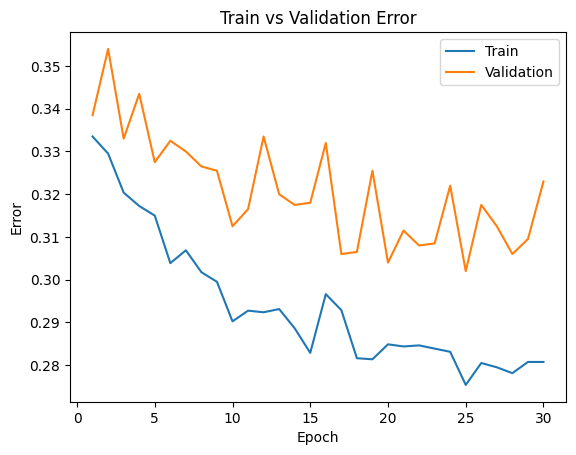

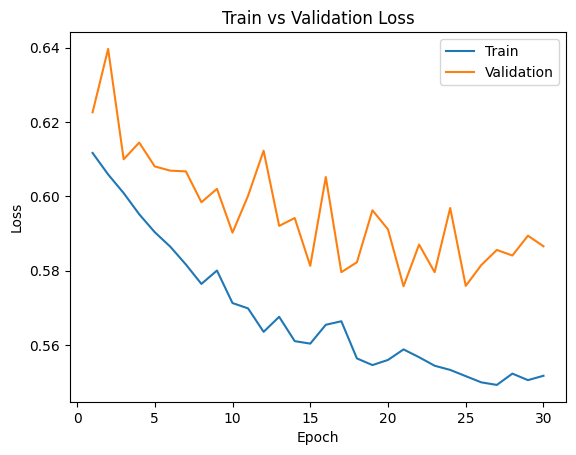

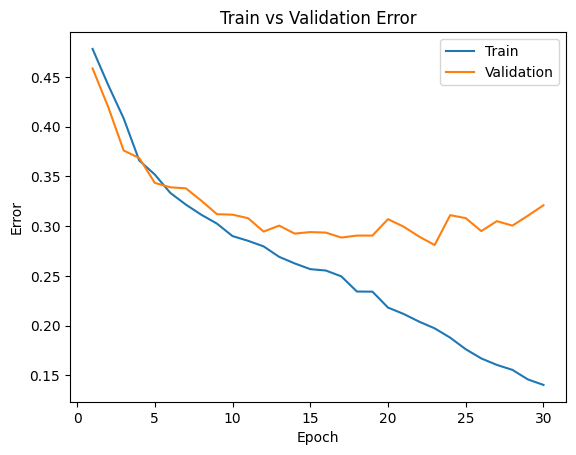

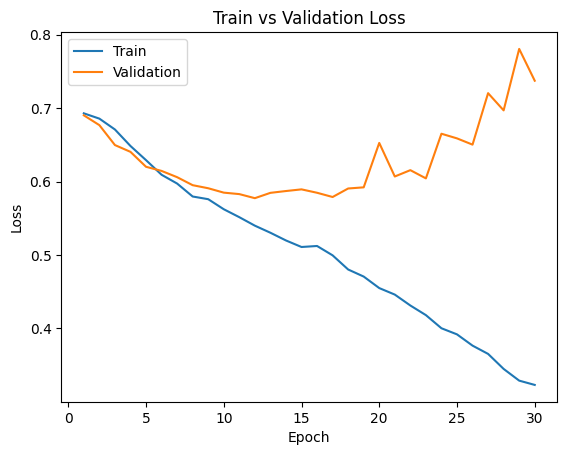

In [ ]:
model_path1 = get_model_name("small", batch_size=64, learning_rate=.01, epoch=29)
plot_training_curve(model_path1)
model_path2 = get_model_name("large", batch_size=64, learning_rate=.01, epoch=29)
plot_training_curve(model_path2)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
"""For both networks training curves, they illustrate a pretty consistent
downward trend, with the large_net showing uniform descent, and the small_net
showing an overall descent with some local areas shooting up and down. However,
the large_net decreases much further and achieves a much lower training error
and loss by the 30th epoch (.137 and .313) achieving a total decrease of about
30% in both error and loss. On the other hand, the small_net only achieves a
final error of .272 and loss of .534, which is significantly higher than the
large net's results. Additionally, the small net only about a 2% decrease in
error and loss, which may indicate underfitting and an inabiity for the network
to learn properly from the training data, leading to poor scores in both the
training and validation data. The large network, on the other hand, shows some
signs of overfitting as the training loss consistently decreases, but the
validation loss begins to skyrocket. This shows that the network is becoming
accustomed to the training data and is memorizing the data rather than
learning."""

"For both networks training curves, they illustrate a pretty consistent\ndownward trend, with the large_net showing uniform descent, and the small_net\nshowing an overall descent with some local areas shooting up and down. However,\nthe large_net decreases much further and achieves a much lower training error\nand loss by the 30th epoch (.137 and .313) achieving a total decrease of about\n30% in both error and loss. On the other hand, the small_net only achieves a\nfinal error of .272 and loss of .534, which is significantly higher than the\nlarge net's results. Additionally, the small net only about a 2% decrease in\nerror and loss, which may indicate underfitting and an inabiity for the network\nto learn properly from the training data, leading to poor scores in both the\ntraining and validation data. The large network, on the other hand, shows some\nsigns of overfitting as the training loss consistently decreases, but the\nvalidation loss begins to skyrocket. This shows that the net

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

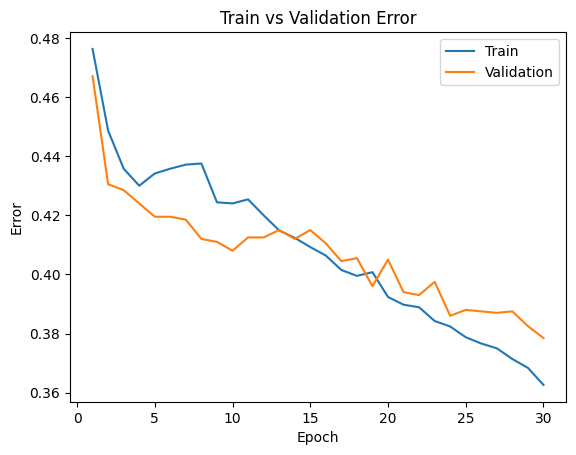

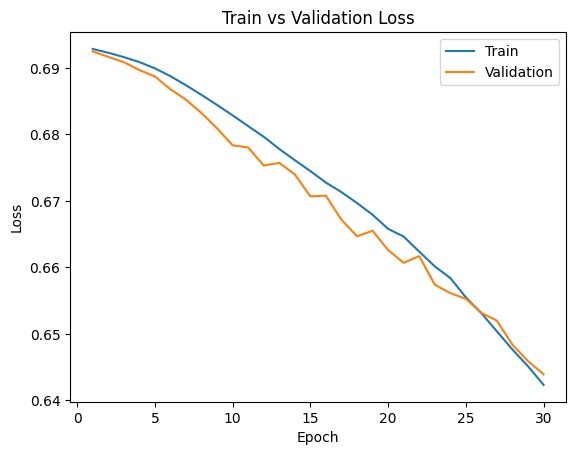

In [ ]:
model_path2 = get_model_name("large", batch_size=64, learning_rate=.001, epoch=29)
plot_training_curve(model_path2)

In [ ]:
"""Lowering the learning rate led to a longer training time by about 3 seconds,
which is not significant. Additionally, it greatly increased the loss and error
and led to underfitting. The model was stepping too slowly (there were not
significant moves made down the gradient) to learn from the data and as a result
the training error and loss are nearly identical to the validation error and
loss. Lowering the learning rate causes the model to take smaller steps down
the gradient and as a result leads to underfitting and the network may struggle
to make any real progress in learning from the training data."""

'Lowering the learning rate led to a longer training time by about 5 seconds.\nAdditionally, it greatly increased the loss and error and led to intense\nunderfitting. The model was stepping too slowly (there were not significant\nmoves made down the gradient) to learn from the data and as a\nresult the training error and loss are nearly identical to the validation error\nand loss. Lowering the learning rate causes the model to take smaller steps\ndown the gradient and as a result leads to underfitting and the network may\nstruggle to make any real progress in learning from the training data.'

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

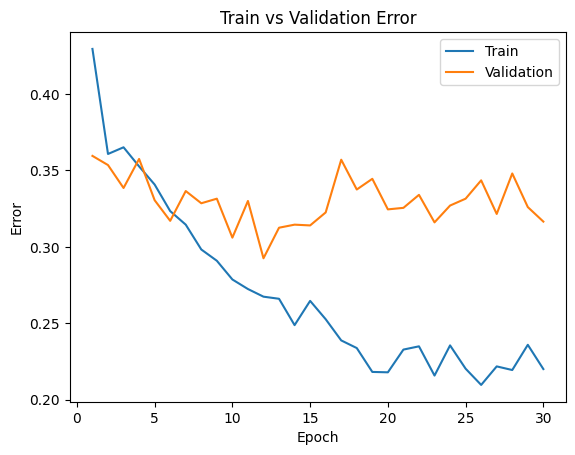

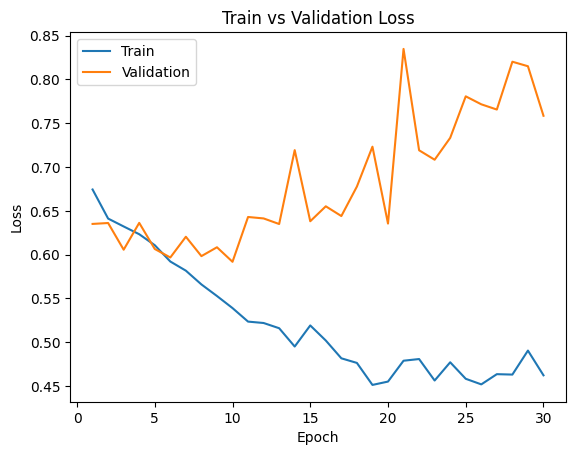

In [ ]:
model_path2 = get_model_name("large", batch_size=64, learning_rate=.1, epoch=29)
plot_training_curve(model_path2)

In [ ]:
"""This model took longer to train than the default model by about 15 seconds.
There appears to be overfitting in this model, shown as the training loss and
error decrease as the validation loss and error increase. Increasing the
learning rate leads to larger steps down the gradient, however these large jumps
often go right over the minima and then diverge outwards."""


'This model took longer to train than the default model by about 10 seconds.\nThere appears to be overfitting in this model, shown as the training loss and\nerror decrease as the validation loss and error increase. Increasing the\nlearning rate leads to larger jumps down the gradient, however these large jumps\noften go right over the minima and then diverge outwards.'

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

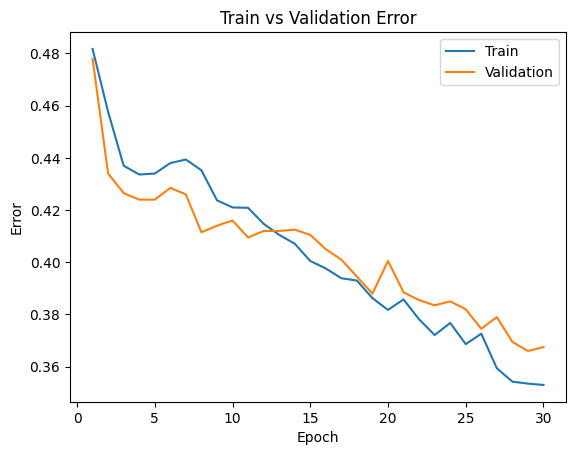

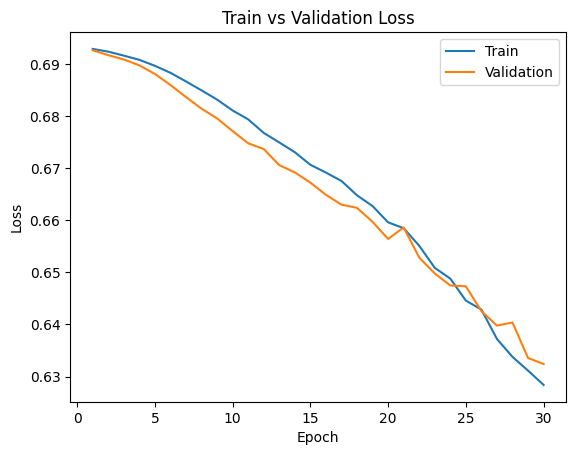

In [ ]:
model_path2 = get_model_name("large", batch_size=512, learning_rate=.01, epoch=29)
plot_training_curve(model_path2)

In [ ]:
"""The model was shorter to train than the default by about 20 seconds. There
appears to be underfitting as the loss and error does not decrease very much as
the number of epochs trained increases. At points the validation error and loss
are lower than the training error and loss. As the batch size is increased the
average loss does not change very much and the model does not make significant
progress as it receives more data."""

'The model was shorter to train than the default by about 3 seconds. There\nappears to be overfitting as the loss and error does not decrease very much as\nthe number of epochs trained increases. As the batch size is increased the\naverage loss does not change very much and the model does not make significant\nprogress as it receives more data.'

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net=LargeNet()
train_net(large_net, 16, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

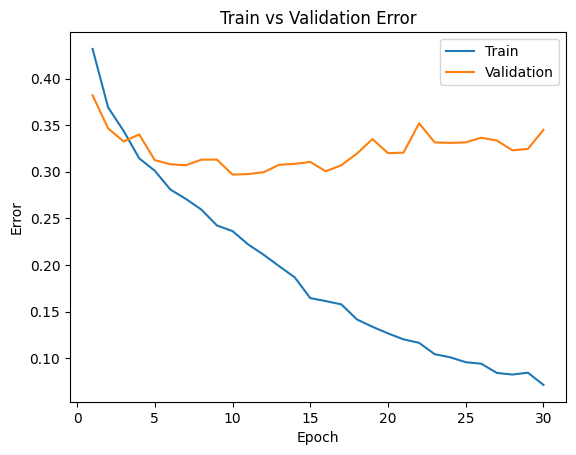

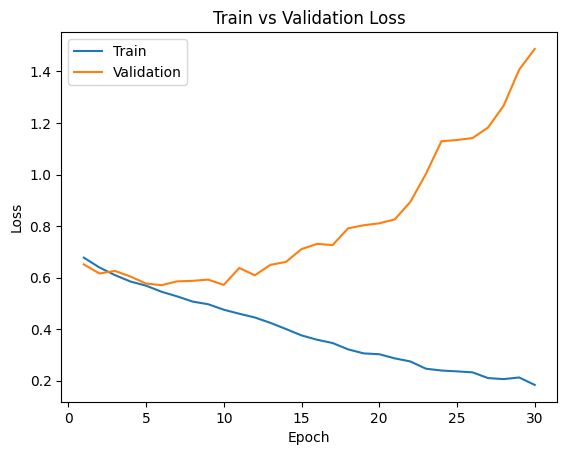

In [ ]:
model_path2 = get_model_name("large", batch_size=16, learning_rate=.01, epoch=29)
plot_training_curve(model_path2)

In [ ]:
"""This model took significantly longer to train (about 60s) than the default.
When the batch size is decreased there is intense overfitting in the data as
the training error and loss decrease consistently while the validation loss
skyrockets and the validation error stops decreasing after about 5 epochs. As
the batch size decreases, the model optimizes for a different function at each
iteration, leading to a failure to recognize any overall trends in the data and
a memorization of training data rather than learning."""

'When the batch size is decreased there is intense overfitting in the data as\nthe training error and loss decrease consistently while the validation loss\nskyrockets and the validation error stops decreasing after about 5 epochs. As\nthe batch size decreases, the model optimizes for a different function at each\niteration, leading to a failure to recognize any overall trends in the data and\na memorization of training data rather than learning.'

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
"""In the original testing with the default parameters, it was clear that the
large_net had more potential than the small_net by it's ability to attain a
much lower training error and loss, however it did overfit the data and the
validation data stopped decreasing. As a result, I wanted to find hyperparam-
eters that would help slow the network down and better fit the data. In order
to accomplish this I decreased the learning rate to 0.007 and increased the
batch size to 128. In part 3, it was evident that lowering the learning rate
decreased the step size and made the model underfit, additionally increasing
the batch size had a similar result. By slightly decreasing the lr and slightly
increasing the batch size, we can still avoid underfitting and hopefully
offset the overfitting observed in the default large network."""

"In the original testing with the default parameters, it was clear that the\nlarge_net had more potential than the small_net by it's ability to attain a\nmuch lower training error and loss, however it did overfit the data and the\nvalidation data stopped decreasing. As a result, I wanted to find hyperparam-\neters that would help slow the network down and better fit the data. In order\nto accomplish this I decreased the learning rate to 0.007 and increased the\nbatch size to 128. In part 3, it was evident that lowering the learning rate\ndecreased the step size and made the model underfit, additionally increasing\nthe batch size had a similar result. By slightly decreasing the lr and slightly\nincreasing the batch size, we can still avoid underfitting and hopefully\noffset the overfitting observed in the default large network."

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.007, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.456625, Train loss: 0.692357723675077 |Validation err: 0.4225, Validation loss: 0.6909653171896935
Epoch 2: Train err: 0.44975, Train loss: 0.6899599754621112 |Validation err: 0.422, Validation loss: 0.6863732673227787
Epoch 3: Train err: 0.430125, Train loss: 0.6856931656125992 |Validation err: 0.412, Validation loss: 0.6801545694470406
Epoch 4: Train err: 0.424125, Train loss: 0.6803461984982566 |Validation err: 0.411, Validation loss: 0.6731148324906826
Epoch 5: Train err: 0.41425, Train loss: 0.6752496967239986 |Validation err: 0.411, Validation loss: 0.6691230647265911
Epoch 6: Train err: 0.40275, Train loss: 0.6695615705989656 |Validation err: 0.396, Validation loss: 0.6658721342682838
Epoch 7: Train err: 0.391375, Train loss: 0.6636068820953369 |Validation err: 0.3935, Validation loss: 0.6578939855098724
Epoch 8: Train err: 0.385875, Train loss: 0.6574361579758781 |Validation err: 0

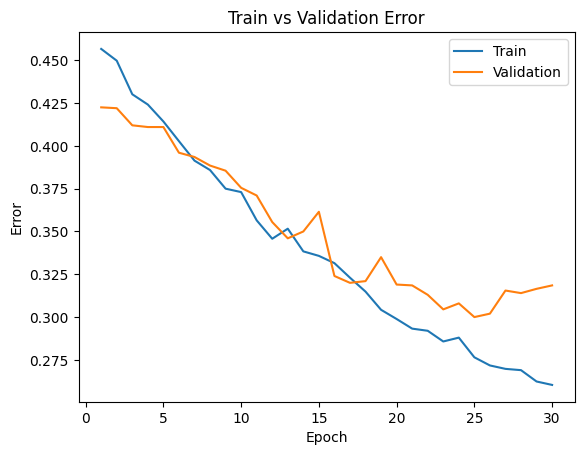

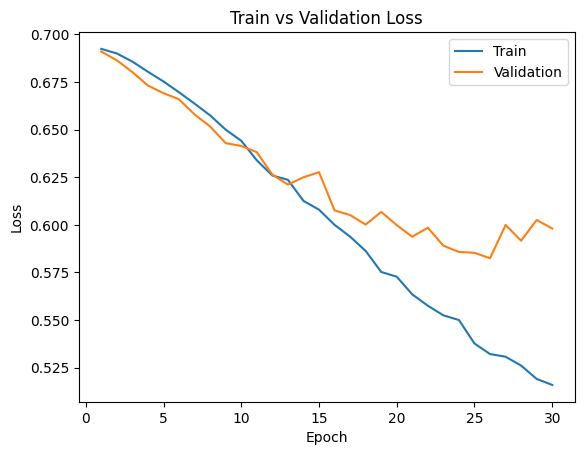

In [ ]:
model_path = get_model_name("large", batch_size=128, learning_rate=.007, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
"""While I was able to achieve a more fit graph, the final totals were not as
low as they could be and there is still some overfitting during the last few
epochs. As a result, I will slightly increase the learning rate to 0.008 in
order to hopefully achieve a smaller error and loss and increase the batch size
to 256 in order to help counter any overfitting caused by the increased
learning rate."""

'While I was able to achieve a more fit graph, the final totals were not as\nlow as they could be and there is still some overfitting during the last few\nepochs. As a result, I will slightly increase the learning rate to 0.008 in \norder to hopefully achieve a smaller error and loss and increase the batch size\nto 256 in order to help counter any overfitting caused by the increased\nlearning rate.'

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 256, 0.008, 30)

Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Train err: 0.476, Train loss: 0.6927500907331705 |Validation err: 0.4465, Validation loss: 0.6921361610293388
Epoch 2: Train err: 0.44925, Train loss: 0.6917554438114166 |Validation err: 0.4425, Validation loss: 0.6904401704668999
Epoch 3: Train err: 0.429125, Train loss: 0.690295547246933 |Validation err: 0.4195, Validation loss: 0.6883374899625778
Epoch 4: Train err: 0.4315, Train loss: 0.6878091357648373 |Validation err: 0.4235, Validation loss: 0.6845168322324753
Epoch 5: Train err: 0.43625, Train loss: 0.6851634550839663 |Validation err: 0.414, Validation loss: 0.6809980198740959
Epoch 6: Train err: 0.425125, Train loss: 0.6823904849588871 |Validation err: 0.4115, Validation loss: 0.6776277869939804
Epoch 7: Train err: 0.41625, Train loss: 0.6789878401905298 |Validation err: 0.409, Validation loss: 0.6740281954407692
Epoch 8: Train err: 0.413125, Train loss: 0.6760749239474535 |Validation err: 0.412, Validation loss: 0.6735102832317352
Epoch 9: Train err: 0.407125, Train 

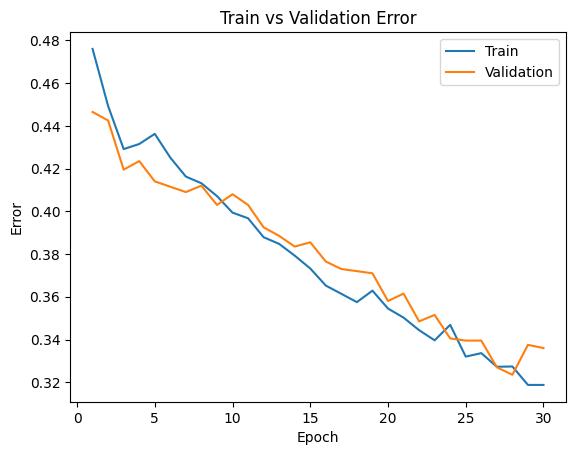

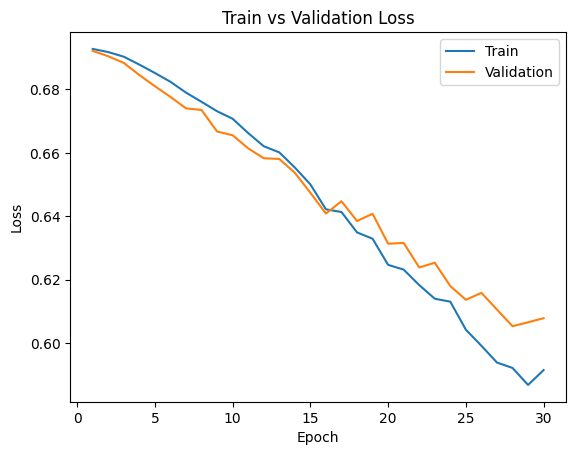

In [ ]:
model=get_model_name("large", batch_size=256, learning_rate=.008, epoch=29)
plot_training_curve(model)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=23)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
"""These hyperparameters achieved the lowest validation error and close to the
lowest validation loss. This means that this model is best equipped to identify
unseen data correctly and performs the best on unseen data out of all of the
models tested. The validation error and loss were .289 and .579 respectively."""

'These hyperparameters achieved the lowest validation error and close to the\nlowest validation loss. This means that this model is best equipped to identify\nunseen data correctly and performs the best on unseen data out of all of the\nmodels tested.'

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
error,loss=evaluate(net, test_loader, nn.BCEWithLogitsLoss())

print(f"\nTest Error: {error}")
print(f"Test Loss: {loss}")


Test Error: 0.312
Test Loss: 0.6565517820417881


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
"""The test error is about .023 higher than the validation error. This makes
sense since after every epoch the model will evaluate itself on the
validation set allowing the model to famialarize itself with the validation set,
but the model only sees the test set once making it impossibleto develop a bias
to the test set."""

'The test error is about .023 higher than the validation error. This makes\nsense since after every epoch the model will evaluate itself on the\nvalidation set allowing the model to famialarize itself with the validation set, \nbut the model only sees the test set once making it impossibleto develop a bias \nto the test set.'

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
"""If we use the test data during training or multiple times, then the network
may develop a bias towards it and it will not give us a true understanding of
how the model reacts to unseen data. The test set must simulate how the model
will respond to real world unseen data, and if the model sees it multiple times
then it will develop a bias and will not generalize well to unseen data."""

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
import numpy as np

test,train,valid,get=get_data_loader(["cat","dog"],64)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 2-layer ANN model

class ANN(nn.Module):
  def __init__(self):
    super(ANN, self).__init__()
    self.layer1 = nn.Linear(3*32*32, 30)
    self.layer2 = nn.Linear(30,1)
    self.name="ann"
  def forward(self,img):
    x=img.view(-1,3*32*32)
    x=self.layer1(x)
    x=self.layer2(F.relu(x))
    return x.squeeze(1)



In [ ]:
ann=ANN()
train_net(ann, 128, 0.0009, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.459375, Train loss: 0.6878309391793751 |Validation err: 0.4155, Validation loss: 0.6790997870266438
Epoch 2: Train err: 0.412625, Train loss: 0.6705285083679926 |Validation err: 0.408, Validation loss: 0.6678757220506668
Epoch 3: Train err: 0.40025, Train loss: 0.6630342791950892 |Validation err: 0.406, Validation loss: 0.6635805740952492
Epoch 4: Train err: 0.396, Train loss: 0.6580023983168224 |Validation err: 0.401, Validation loss: 0.6596299260854721
Epoch 5: Train err: 0.38925, Train loss: 0.6542168836745005 |Validation err: 0.402, Validation loss: 0.6577428691089153
Epoch 6: Train err: 0.38475, Train loss: 0.6514854828516642 |Validation err: 0.403, Validation loss: 0.6568627469241619
Epoch 7: Train err: 0.38075, Train loss: 0.6487447326145475 |Validation err: 0.3965, Validation loss: 0.6548548340797424
Epoch 8: Train err: 0.374625, Train loss: 0.6461559732755026 |Validation err: 0.39

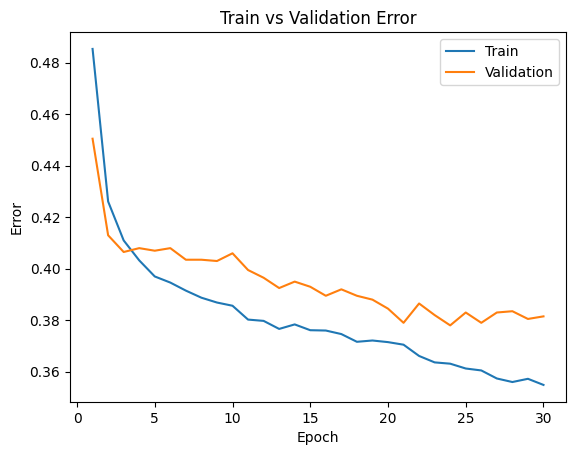

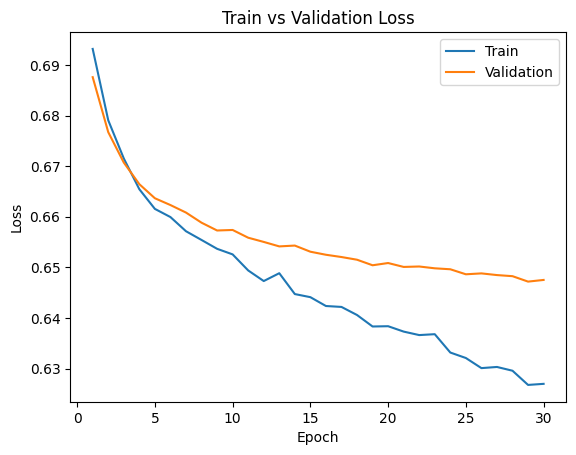

In [ ]:
annmodel=get_model_name("ann", 128, 0.0009, 29)
annmodel
plot_training_curve(annmodel)

In [ ]:
annerror,annloss=evaluate(ann, test, nn.BCEWithLogitsLoss())

print(f"\nANN Test Error: {annerror}")
print(f"ANN Test Loss: {annloss}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



ANN Test Error: 0.323625
ANN Test Loss: 0.6037694358825684


In [ ]:
"""The ANN test error is higher than the best CNN model's test error.
Additionally, when looking at the training and validation error, the ANN
performs significantly worse than the CNN. As a result, I can safely say that
the CNN is a better model to classify cat and dog images than the ANN."""